# Analyze HACC IO

## Global Configurations

In [1]:
notebook_name = "hacc"

## System Imports

In [2]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [3]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [4]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "02:00" # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker
n_workers = 4 # number of workers to be used for analysis

Other configurations we can compute

In [5]:
host = socket.gethostname()
dashboard_address = '{}:8787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [6]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     use_stdin=True, host = host,dashboard_address = dashboard_address)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 1
#BSUB -G asccasc
#BSUB -q pdebug
#BSUB -W 02:00
#BSUB -o hacc.log
#BSUB -e hacc.log
JOB_ID=${LSB_JOBID%.*}

/usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.200:34875 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 60



/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42461 instead
  warnings.warn(


### Dask Analysis Imports

In [7]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [8]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:42461/status,
Dashboard: http://192.168.66.200:42461/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:34875,Workers: 0
Dashboard: http://192.168.66.200:42461/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [9]:
cluster.scale(n_workers)

In [10]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val< n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 3 of 4
4 workers started


## Analysis Utility Functions

### Progress Bars

In [11]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [12]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [13]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

In [14]:
parquet_folder="/p/gpfs1/iopp/parquet_app_logs/hacc/nodes-32/workflow-0"

In [15]:
num_ranks = 160

## Initial Boostrapping

### Read Application logs into dask dataframe

In [16]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [17]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 160 partitions


In [18]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')


In [19]:
ddf.head()

,index,rank,thread_id,cat,tstart,tend,func_id,level,arg_count,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,0,312784,2,0.968866,0.968892,MPI_Comm_size,0,2,MPI_COMM_WORLD,1280,,,,,,,,
1,2,0,312784,2,0.968923,0.968924,MPI_Comm_rank,0,2,MPI_COMM_WORLD,0,,,,,,,,
2,3,0,312784,4,1.127011,1.127014,/usr/workspace/iopp/applications/hacc-io.1.0/i...,0,0,,,,,,,,,,
3,4,0,312784,2,1.127036,4.299232,MPI_Comm_dup,0,3,MPI_COMM_WORLD,0-0,0,,,,,,,
4,5,0,312784,0,4.298360,4.298391,open,1,3,/dev/shm/job2154496201-35619-OMPI_COLL_IBM-0-c...,557250,384,,,,,,,


#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [20]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [21]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

### Check I/O interfaces used by application

In [22]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0         open
1    ftruncate
2        close
3       unlink
4       open64
5      lseek64
6        write
7         read
Name: func_id, dtype: object


Only POSIX interface is used in this application

### Set duration of I/O events

In [23]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [24]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [25]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [26]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [27]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [28]:
io_ddf_read_write = io_ddf[read_condition | write_condition].compute()
io_ddf_metadata = io_ddf[~read_condition & ~write_condition].compute()

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [29]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [30]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [31]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [32]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [33]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [34]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [35]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [36]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

The application accesses 1280 files across all ranks


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [37]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,2.560000e+04,25600.000000
mean,6.627000e+07,3156.667067
std,2.716978e+07,2674.335676
min,2.516582e+07,17.803329
25%,6.710886e+07,856.953229
50%,6.710886e+07,2708.842514
75%,6.710886e+07,4141.116546
max,1.342177e+08,10253.455157


### Preload the I/O dataframe for faster analysis

In [38]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

## Application Analysis

### Num Ranks

In [39]:
num_ranks = io_ddf_read_write['rank'].nunique()
print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 1280


### Total I/O amount

In [40]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 1580.0 GB
Total I/O per operation in application func_id
read     790.0
write    790.0
Name: size, dtype: float64 GB


### I/O per rank

In [41]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     read       662700032
      write      662700032
1     read       662700032
      write      662700032
2     read       662700032
                   ...    
1277  write      662700032
1278  read       662700032
      write      662700032
1279  read       662700032
      write      662700032
Name: size, Length: 2560, dtype: int32

Every rank performs the same amount of I/O and is evenly distributed amoung the read and write operations

<AxesSubplot:xlabel='rank'>

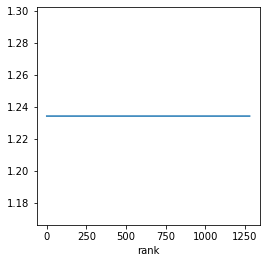

In [42]:
io_per_rank_gb = io_ddf_read_write.groupby(['rank'])['size'].sum()/1024.0/1024.0/1024.0
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Operations Per Rank

<AxesSubplot:xlabel='rank'>

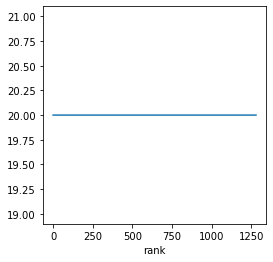

In [43]:
io_per_rank_gb = io_ddf_read_write.groupby('rank')['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Average I/O Time per process

In [44]:
time_per_rank = io_ddf_read_write.groupby('rank')['duration'].sum()

In [45]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 1.406298279762268 sec, Max 3.7613401412963867 sec, and Min 0.23242568969726562 sec


<AxesSubplot:xlabel='rank'>

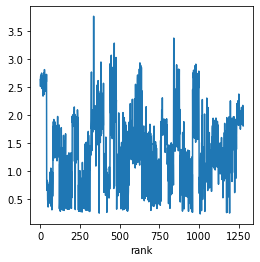

In [46]:
time_per_rank.plot(kind='line',figsize=(4,4))

Even though every rank has identical I/O (operations and amount), they have a variable performance.
- **Possible Reason:**
  - Overwelming of PFS from I/O parallelism.
  - Transfer size doesnt match Stripe size.

### Compute Time

#### Convert trace dataframe into memory.

In [47]:
trace_ddf_local = trace_ddf.compute()

#### Calculate duration for trace values

In [48]:
trace_ddf_local['duration'] = trace_ddf_local['tend']-trace_ddf_local['tstart']

In [49]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 0 negetive rows


In [50]:
time_per_rank = trace_ddf_local.groupby('rank')['duration'].sum()

In [51]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average 6.418972015380859 sec, Max 10.984901428222656 sec, and Min 1.9412412643432617 sec


<AxesSubplot:xlabel='rank'>

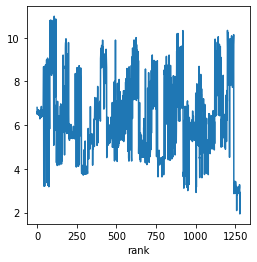

In [52]:
time_per_rank.plot(kind='line',figsize=(4,4))

## Job Time

In [53]:
job_time = ddf['tend'].max().compute()

In [54]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 33.702091217041016 sec


The application run for a long time includes initialization.

## Job Intensity

In [55]:
total_compute = trace_ddf_local.groupby('rank')['duration'].sum().max()
total_io = io_ddf.groupby('rank')['duration'].sum().max().compute()

In [56]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [57]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: 0.4855409292837764, Compute intensity: 0.5144590707162237


## Time spent in Data Operations

In [58]:
data_ops = ['read', 'write']
total_time_io_data = io_ddf[io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

Time spent on data: 3.7613401412963867 sec, metadata: 8.796525001525879 sec


### I/O Transfer Size Distribution

[0, 0, 0, 0, 25600]


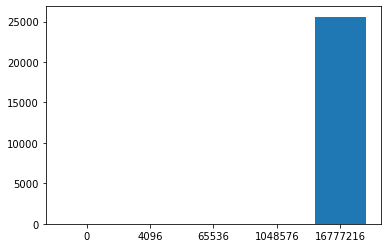

In [88]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

The application uses a constant transfer size of 16MB

### Distribution of Bandwidth achived by application

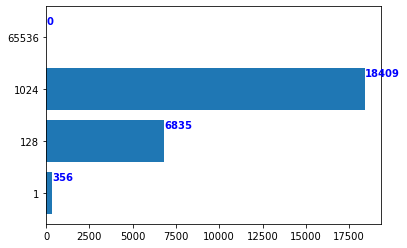

In [60]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [61]:
request_bw

[356, 6835, 18409, 0]

In [62]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([ 1.390625  , 26.69921875, 71.91015625,  0.        ])

nan nan


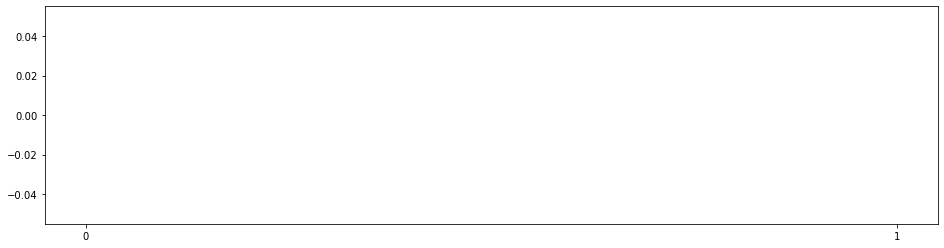

nan nan


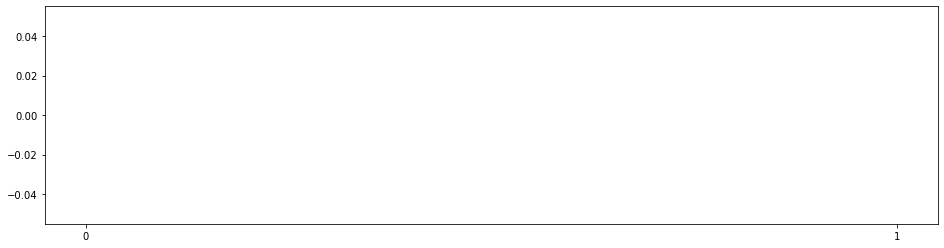

nan nan


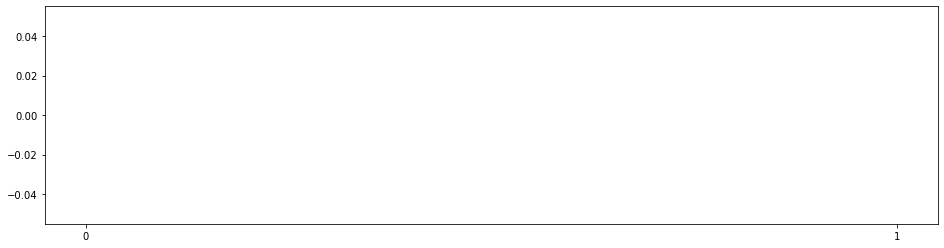

nan nan


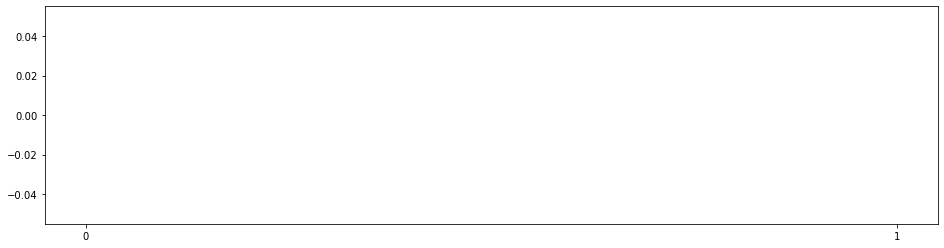

1548.0558852854424 1935.1189530371353


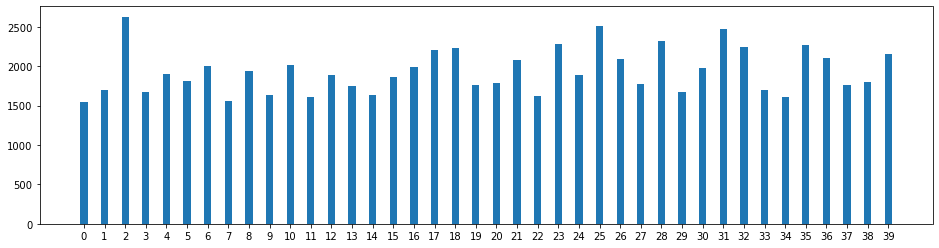

In [87]:
ranks = range(40)
ranks_str = []
for rank in ranks:
    ranks_str.append(str(rank))
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(ranks)
    for j,rank in enumerate(ranks):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.mean(request_size[i]))
    rects1 = plt.bar(ranks_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

- 71% of the overall I/O got a bandwidth of 1 GB/s per process.
- 27% achieve a low bandwidth of 128MB/s

### Number of files read/written

In [63]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 1280 files


### I/O Operations by Application

In [64]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
close         7680
ftruncate     2560
lseek64      25600
open          3808
open64        5120
read         12800
unlink        2560
write        12800
Name: func_id, dtype: int64

As there are 1280 ranks in total, the distribution of operations is even among the processes.
We will confirm it with random inspections next.

### IO Operations per rank

In [65]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:8]

rank  func_id  
0     close         6
      ftruncate     2
      lseek64      20
      open          3
      open64        4
      read         10
      unlink        2
      write        10
Name: func_id, dtype: int64

In [66]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[32:40]

rank  func_id  
4     close         6
      ftruncate     2
      lseek64      20
      open          3
      open64        4
      read         10
      unlink        2
      write        10
Name: func_id, dtype: int64

These confirm our hypothesis that HACC-IO performs same operations per process.

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

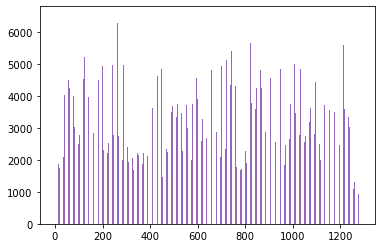

/var/tmp/ipykernel_94540/3804279530.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


In [67]:
ranks = range(num_ranks)
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*num_ranks
    for rank in range(num_ranks):
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][rank] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][rank] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
fig, ax = plt.subplots()
width = 0.35
for i, val in enumerate(size_ranges):
    rects1 = ax.bar(ranks, request_size[i], width, label=str(i))
plt.show()
ax.legend()

fig.tight_layout()

plt.show()

As the application has only one request size 16MB, we see a single line. However, we see variation of upto 10x between bandwidth from few ranks.

### Overlapping of Compute and I/O

In [68]:
io_ddf.groupby('rank')['thread_id'].nunique().describe().compute()

count    1280.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [69]:
time_step=1 # in seconds

#### Request Size Timeline

[0.0, 0.0, 0.0, 0.0, 0.0, 4.5, 16.25, 0.703125, 0.3046875, 0.890625, 43.953125, 24.3125, 120.7421875, 67.0625, 50.5, 57.1328125, 75.7734375, 47.9375, 61.921875, 90.1484375, 73.875, 163.671875, 126.7890625, 71.640625, 236.734375, 54.5, 10.28125, 4.546875, 16.1875, 6.5625, 3.625, 18.625, 0.0, 0.0]


<BarContainer object of 34 artists>

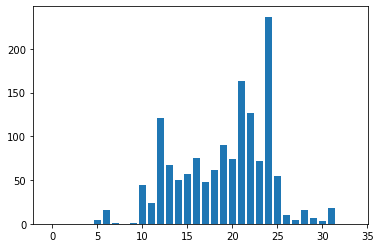

In [91]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

The initial part of the application is spent on init. Based on code inspection this is memory allocation. Then we have I/O operations. Also, as the application has same number of ops a variatic graph depicts that the I/O performance is not consistant during the runtime. Specifically, the I/O performance can reduce 2x-10x during runtime of application.

#### Bandwidth Timeline

[nan, nan, nan, nan, nan, 0.8095552703955399, 1.358728256925966, 4.652142028826744, 3.761858100071161, 2.356318302045494, 1.782752921620369, 2.7402682501724582, 3.202361865856468, 3.56613248324311, 3.94240436532523, 4.55295733374272, 3.8489681544533063, 5.554381469629488, 3.560163332316309, 3.2571413285175237, 3.6401121443665083, 3.274907278567342, 3.651006323614951, 3.645205107738523, 2.269931172455765, 2.4125518183235326, 2.874886008722048, 7.160397948614236, 2.1623864275060214, 3.2677888560794077, 1.6512704655259043, 2.3534860485041698, nan, nan]


<BarContainer object of 34 artists>

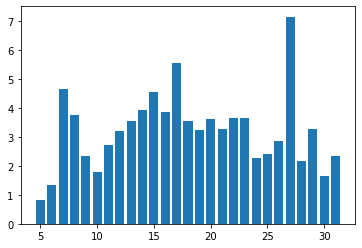

In [93]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

This supports our previous observation as the bandwidth is the measure of I/O performance of the application.

#### Bandwidth Timeline Per Rank

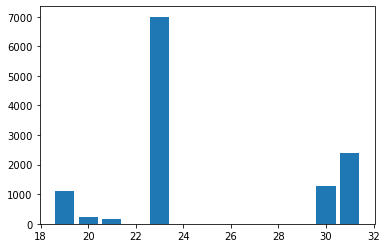

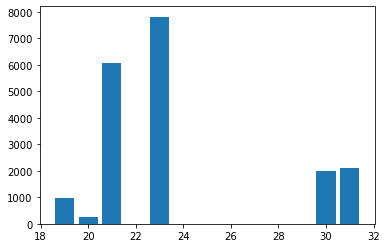

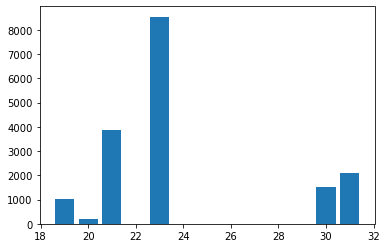

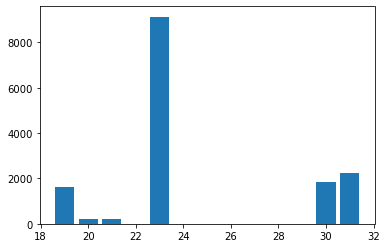

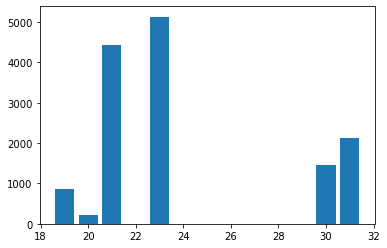

In [72]:
import math

selected_rank = [0, 4, 8, 12, 20]
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    prev = 0
    for i in values_int:
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    plt.bar(values, timeline_ts)
    plt.show()

As each of the processes in the job perform the same work, the variation in bandwidth means we can optimize the workflow with buffering and caching to reduce the stress and network congestions on the PFS.

#### Request Size Timeline per Rank

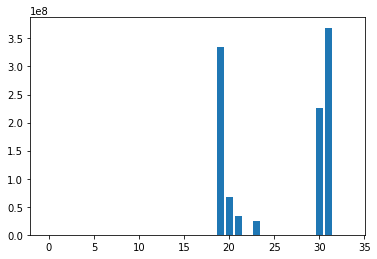

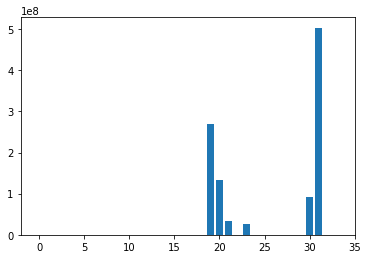

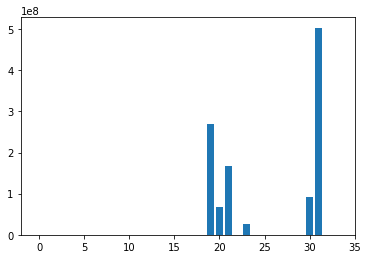

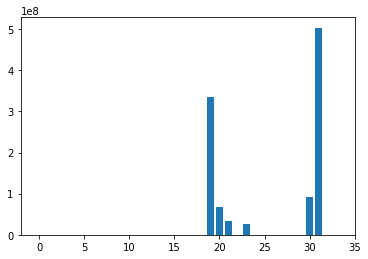

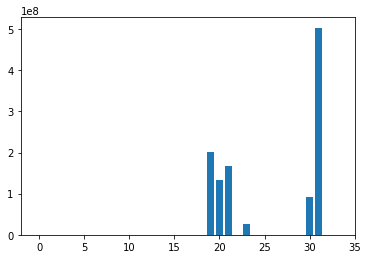

In [73]:
import math

selected_rank = [0, 4, 8, 12, 20]
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    prev = 0
    for i in values_int:
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()
        prev = values[i]
    plt.bar(values, timeline_ts)
    plt.show()

### Data Flow
We plot how different ranks in the job are accessing data.

In [74]:
dependency_graph = {}
for filename in all_filenames:
    dependency_graph[filename]={}

In [98]:
import graphviz
dot = graphviz.Digraph("rank0",format='pdf')
for rank in [0]:
    dot.node(str(rank))
    io_access_rank = io_ddf[io_ddf['rank'] == rank].groupby(['filename','func_id'])['func_id'].count().compute()
    #print(io_access_rank)
    for index,item in io_access_rank.iteritems():
        filename = index[0]
        func_id = "{}-{}".format(rank,index[1])
        count = item
        #print(filename,func_id,count)
        if "/p/gpfs1" in filename:
            #if filename not in dependency_graph:
            #    dependency_graph[filename]={}
            #if rank not in dependency_graph[filename]:
            #    dependency_graph[filename][rank] = {}
            #if index[1] not in dependency_graph[filename][rank]:
            #    dependency_graph[filename][rank][index[1]] = 0
            #dependency_graph[filename][rank][index[1]] += count
            dot.node(func_id)
            dot.node(filename)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(filename, func_id, label=str(count))
            else:
                dot.edge(func_id,filename, label=str(count))
        

In [101]:
print(dot.source)

digraph rank0 {
	0
	"0-close"
	"/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data"
	0 -> "0-close"
	"0-close" -> "/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data" [label=4]
	"0-open64"
	"/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data"
	0 -> "0-open64"
	"0-open64" -> "/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data" [label=4]
	"0-read"
	"/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data"
	0 -> "0-read"
	"/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data" -> "0-read" [label=10]
	"0-write"
	"/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data"
	0 -> "0-write"
	"0-write" -> "/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data" [label=10]
}


In [103]:
!dot -Tpdf rank0.dot > rank0.pdf

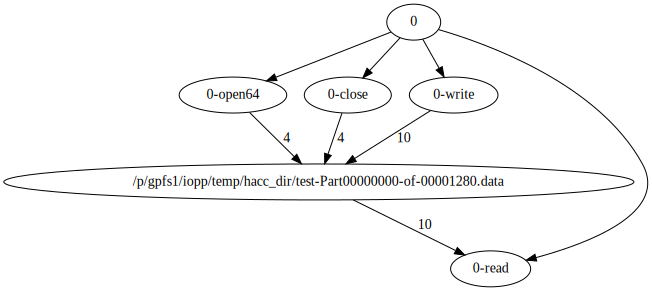

In [99]:
dot

Through this we can hypothesize that each process is independently reading and writing data.

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [77]:
thread_index_series = io_ddf.groupby(['rank', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [78]:
io_ddf['thread_index'] = 0
for index,item in thread_index_series.iteritems():
    condition = (io_ddf['rank'] == index[0]) & (io_ddf['thread_id'] == index[1])
    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [79]:
threads = io_ddf['thread_index'].nunique().compute()
print("We have {} threads across {} ranks".format(threads, num_ranks))

We have 1280 threads across 1280 ranks


In [80]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['thread_index'].nunique().compute()

In [81]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

1280 files that are accessed by application by only one rank


In [82]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

0 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [83]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Get File operations per rank and per file from the dataframe

In [84]:
selected_ranks = [0]#range(num_ranks)##
file_per_rank_df = [{}]*len(selected_ranks)
for rank in selected_ranks:
    file_per_rank_df[rank]={}
    io_ddf_rank = io_ddf[io_ddf['rank'] == rank]
    unique_files = io_ddf_rank['filename'].unique().compute()
    for filename in unique_files:
        if filename != '' and '/p/gpfs1' in filename:
            file_per_rank_df[rank][filename] = io_ddf_rank[io_ddf_rank['filename'] == filename].compute()
        

### Check Pattern
We just check if seeks are used. If not it uses a sequential pattern.

In [85]:
for rank, file_per_rank_df_single in enumerate(file_per_rank_df):
    for filename in file_per_rank_df_single:
        file_df = file_per_rank_df_single[filename]
        ops = file_df['func_id'].unique()
        if "seek" not in ops:
            print("file {} is acessed sequentially by rank {}".format(filename, rank))

file /p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data is acessed sequentially by rank 0


There is no seek in any of the file access hence they are sequentially accessed overall.

### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [86]:
temp_df = io_ddf_read_write
per_file_df = io_ddf_read_write.groupby(['filename'])
temp_df['size_sum'] = per_file_df[["size"]].transform(sum)
temp_df['size_sum'] = temp_df['size_sum'] / 1024.0 / 1024.0
temp_df['time_sum'] = per_file_df[["duration"]].transform(sum)
temp_df['bw_sum'] = per_file_df[["bandwidth"]].transform(np.mean)

per_file_size = temp_df.sort_values("size_sum", ascending=False)["size_sum"]
per_file_time = temp_df.sort_values("time_sum", ascending=False)["time_sum"]
per_file_bw = temp_df.sort_values("bw_sum", ascending=False)["bw_sum"]
print(per_file_size.head())
print(per_file_time.head())
print(per_file_bw.head())

35     1264.0
679    1264.0
728    1264.0
725    1264.0
722    1264.0
Name: size_sum, dtype: float64
63     3.76134
59     3.76134
105    3.76134
102    3.76134
99     3.76134
Name: time_sum, dtype: float32
47    6480.453861
75    6480.453861
44    6480.453861
41    6480.453861
35    6480.453861
Name: bw_sum, dtype: float64
